In [1]:
import tensorflow as tf
import numpy as np 
from glob import glob
import cv2
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
import os

In [2]:
SIZE = 512
data_dir = "./mydataset/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

images = sorted(glob(os.path.join(image_dir, "*.jpg")))
masks = sorted(glob(os.path.join(mask_dir, "*.png")))

train_images = []
train_masks = []

for img_path, mask_path in zip(images, masks):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (512, 512))
    img = img / 255.0  

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512)) 
    mask = mask / 255.0  

    train_images.append(img)
    train_masks.append(mask)

X = np.array(train_images)
y = np.expand_dims(np.array(train_masks), axis=-1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[SIZE, SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[SIZE, SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
OUTPUT_CLASSES = 1

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [18]:
history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.9325
Epoch 1: val_loss improved from inf to 0.64427, saving model to mazsola.h5
19/19 [==============================] - 11s 432ms/step - loss: 0.5534 - accuracy: 0.9325 - val_loss: 0.6443 - val_accuracy: 0.9067
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.9358
Epoch 2: val_loss improved from 0.64427 to 0.44201, saving model to mazsola.h5
19/19 [==============================] - 7s 366ms/step - loss: 0.3739 - accuracy: 0.9358 - val_loss: 0.4420 - val_accuracy: 0.9039
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9355
Epoch 3: val_loss improved from 0.44201 to 0.41259, saving model to mazsola.h5
19/19 [==============================] - 7s 358ms/step - loss: 0.2870 - accuracy: 0.9355 - val_loss: 0.4126 - val_accuracy: 0.9084
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.93

1/1 [==============================] - 0s 40ms/step


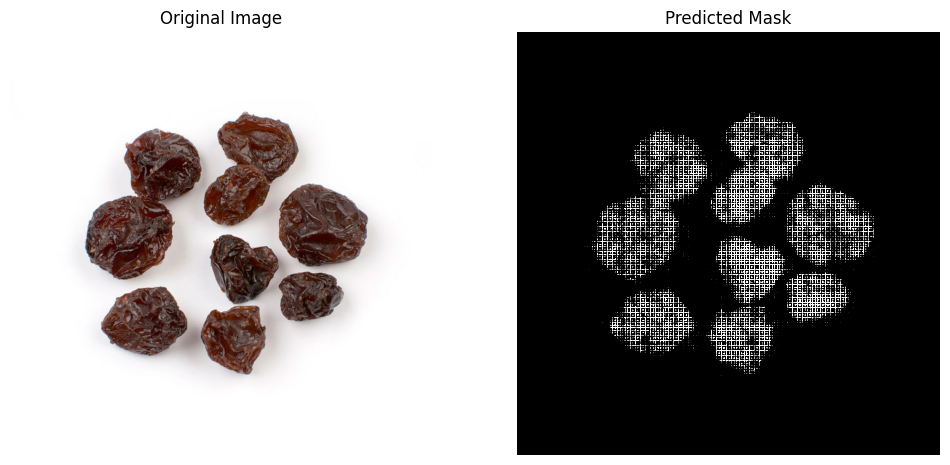

In [25]:
timage = cv2.imread("81.jpg", cv2.IMREAD_COLOR)
timage = timage / 255.0
timage = cv2.resize(timage, (512, 512))
timage = np.expand_dims(timage, axis=0)
predicted_mask = model.predict(timage)

import matplotlib.pyplot as plt
# Kép és maszk megjelenítése egymás mellett
plt.figure(figsize=(12, 6))

# Eredeti kép
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread("81.jpg"), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Prediktált maszk
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0],  cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()